In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


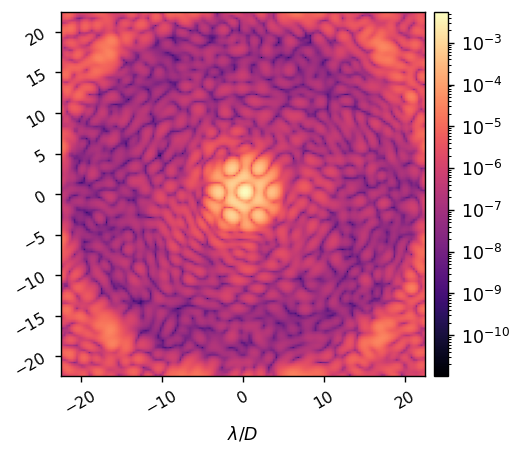

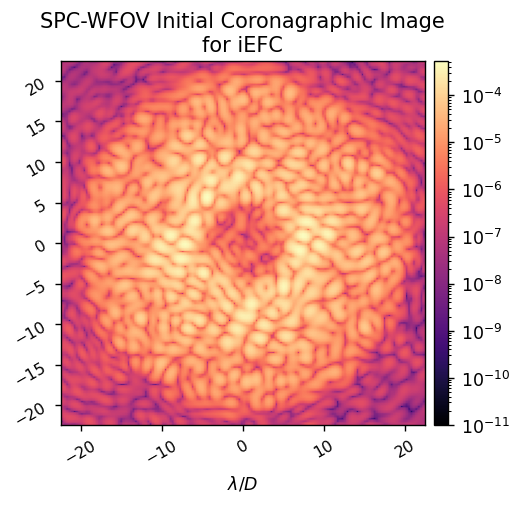

In [2]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=148,
                                  use_pupil_defocus=True, 
                                  use_opds=True)
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

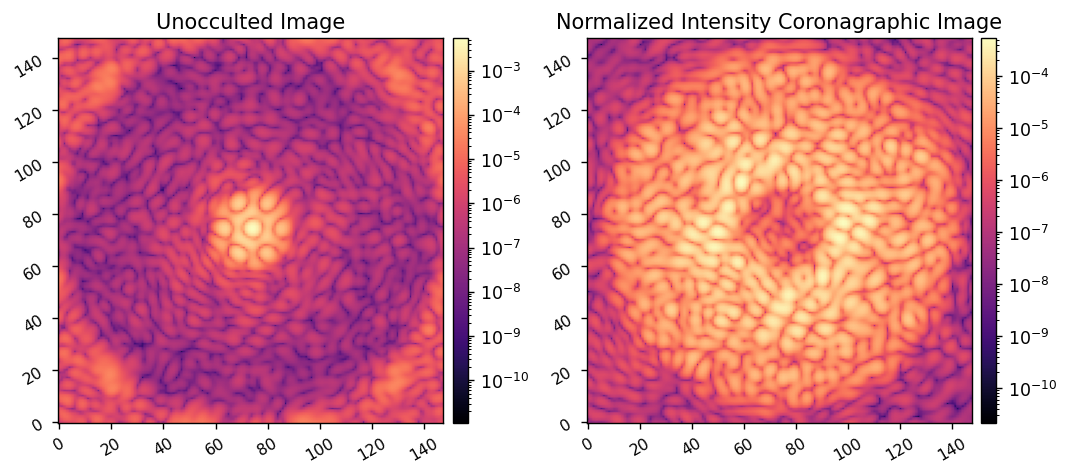

In [4]:
imshow2(ref_unocc_im, ref_im, 'Unocculted Image', 'Normalized Intensity Coronagraphic Image', lognorm=True)

# Create dark hole ROI to calibrate and control

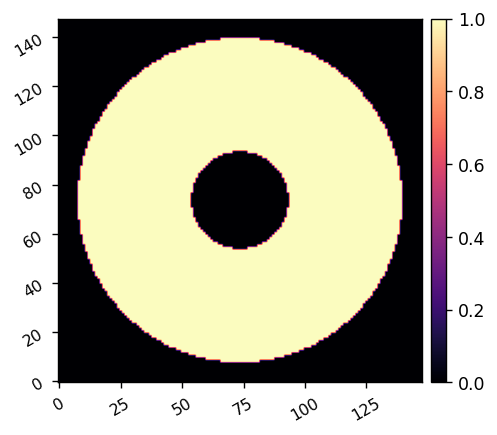

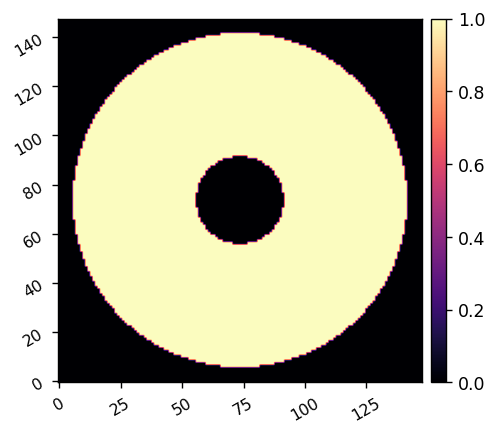

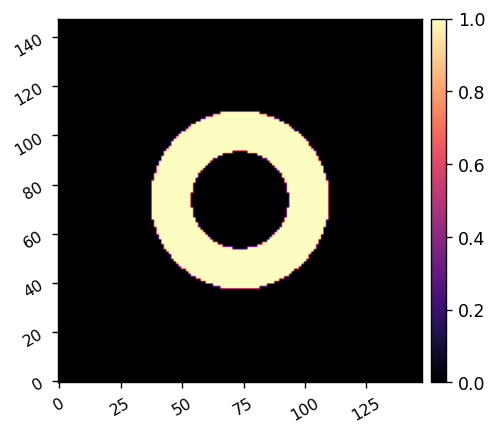

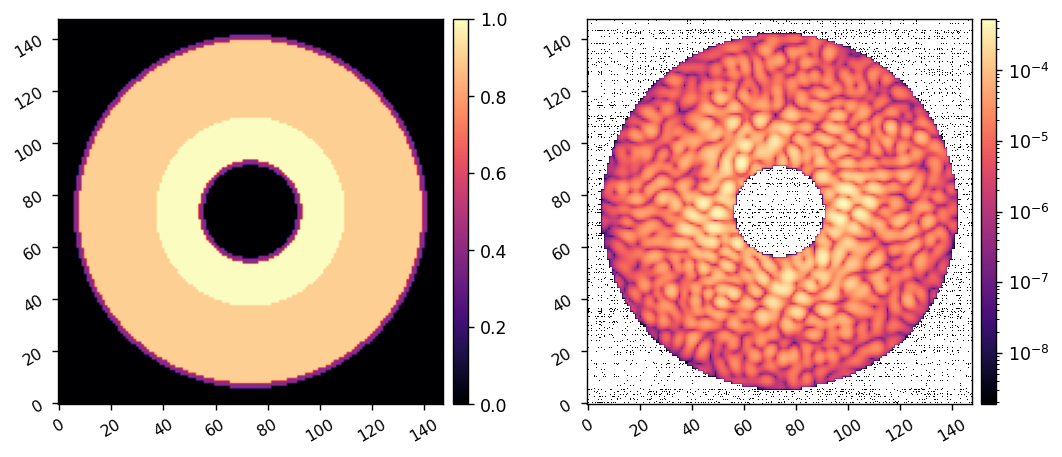

3.042688486608365e-05


In [3]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None, plot=True)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration and probe modes

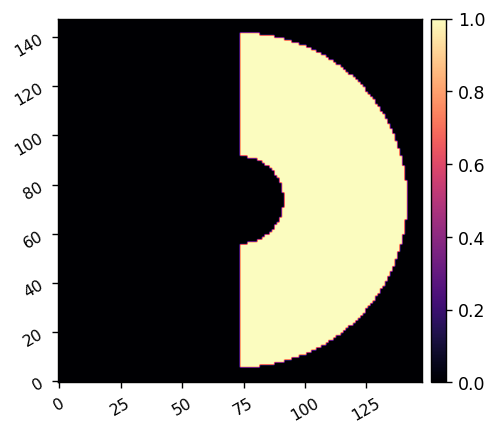

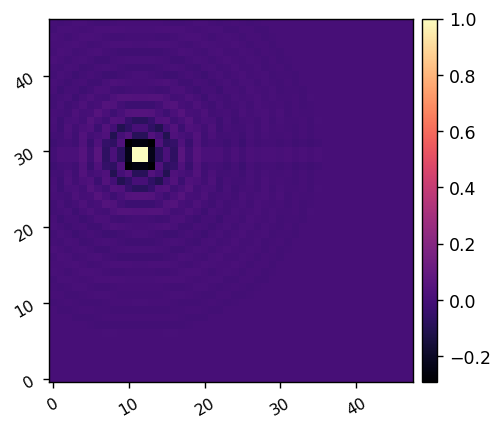

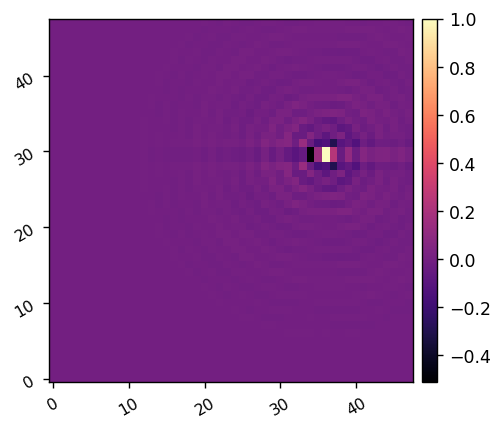

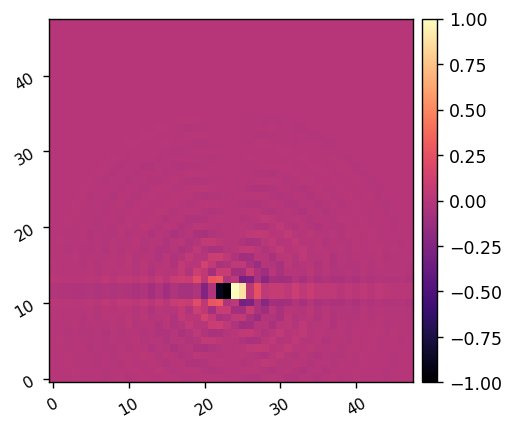

In [6]:
reload(utils)

half_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=0, plot=True)
probe_amp = 2.5e-8
probe_modes = utils.create_fourier_probes(mode, half_mask, fourier_sampling=0.2, shift=[(-12,6), (12,6), (0,-12)], nprobes=3, plot=True)


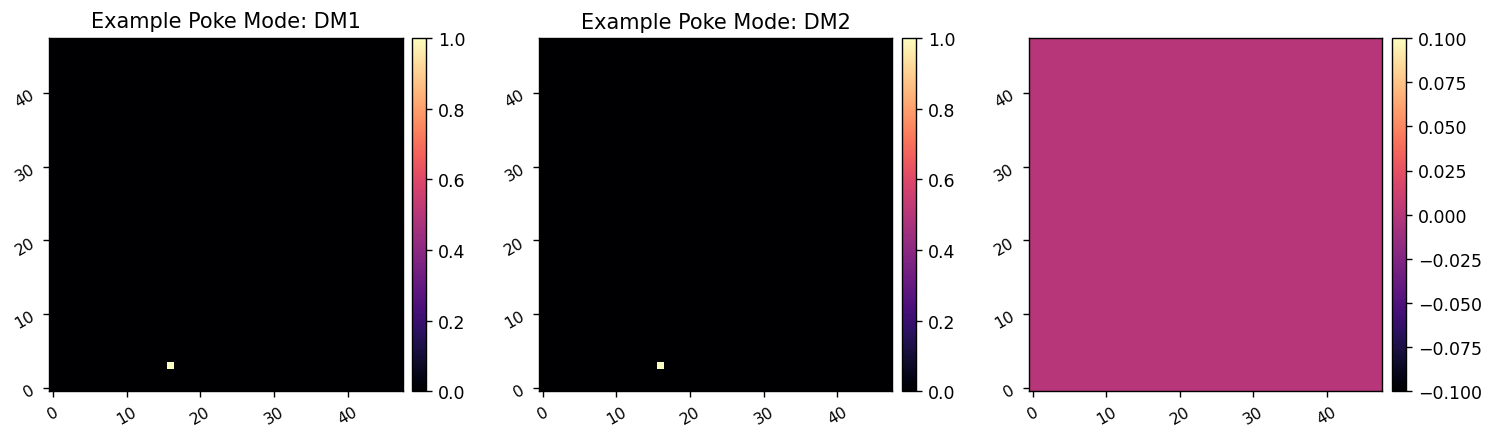

In [17]:
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)
i = 52
dm1_mode = calib_modes[i][:mode.Nact**2].reshape(mode.Nact,mode.Nact)
dm2_mode = calib_modes[i+calib_modes.shape[0]//2][mode.Nact**2:].reshape(mode.Nact,mode.Nact)
imshow3(dm1_mode, dm2_mode, dm1_mode-dm2_mode, 
        'Example Poke Mode: DM1', 'Example Poke Mode: DM2')

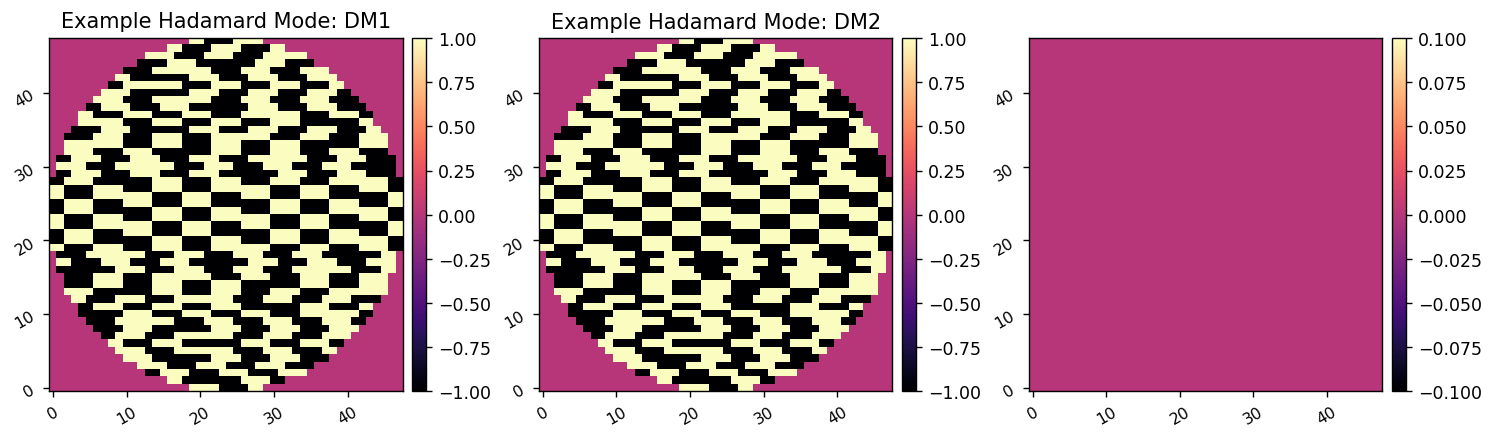

(4096, 4608)

In [18]:
reload(utils)
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
i = 52
dm1_mode = calib_modes[i][:mode.Nact**2].reshape(mode.Nact,mode.Nact)
dm2_mode = calib_modes[i+calib_modes.shape[0]//2][mode.Nact**2:].reshape(mode.Nact,mode.Nact)
imshow3(dm1_mode, dm2_mode, dm1_mode-dm2_mode, 
        'Example Hadamard Mode: DM1', 'Example Hadamard Mode: DM2')
calib_modes.shape

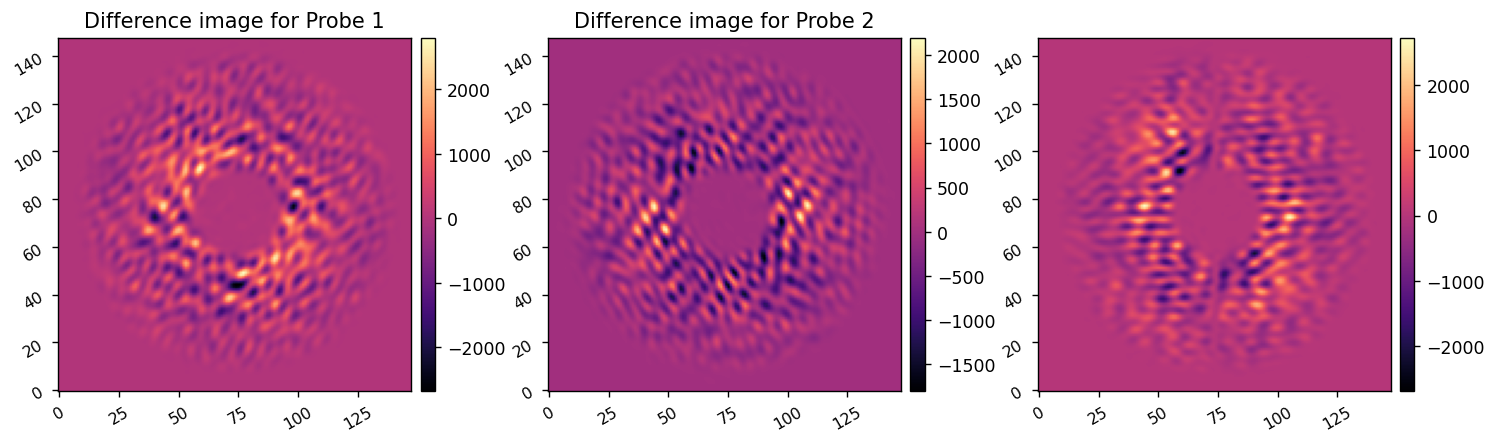

In [7]:
reload(iefc_2dm)

differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
imshow3(ims[0], ims[1], ims[2], 'Difference image for Probe 1', 'Difference image for Probe 2')

In [39]:
reload(iefc_2dm)

response_matrix, response_cube = iefc_2dm.calibrate(mode, control_mask, probe_amp, probe_modes, calib_amp, calib_modes, return_all=True)
utils.save_fits(response_dir/f'spc_wfov_iefc_2dm_poke_response_matrix_{today}.fits', response_matrix)
utils.save_fits(response_dir/f'spc_wfov_iefc_2dm_poke_response_cube_{today}.fits', response_cube)


Calibrating iEFC...
	Calibrated mode 1804/1804 in 8371.131s
Calibration complete.
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_iefc_2dm_poke_response_matrix_20230728.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_iefc_2dm_poke_response_cube_20230728.fits


In [10]:
# date = 20230630
# date = 20230703
date = 20230713
response_matrix = xp.array(fits.getdata(iefc_dir/'response-data'/f'spc_wide_iefc_2dm_poke_response_matrix_{date}.fits'))
response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/f'spc_wide_iefc_2dm_poke_response_cube_{date}.fits'))

In [17]:
response_cube.shape

(3560, 2, 4096)

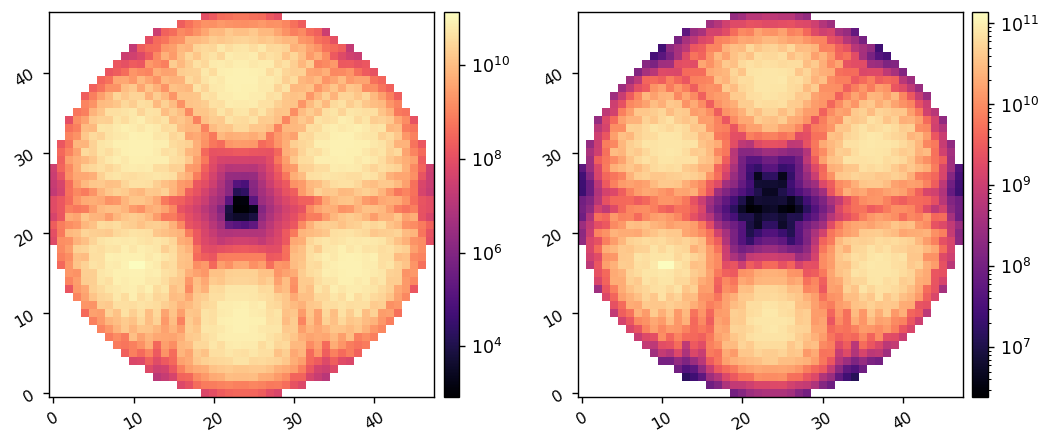

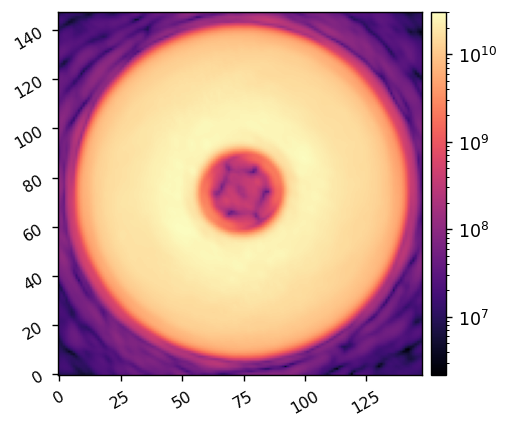

In [41]:
reload(utils)
dm1_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,:mode.Nacts]**2, axis=0)), mode.dm_mask)
dm2_response = utils.map_acts_to_dm(xp.sqrt(xp.sum(response_matrix[:,mode.Nacts:]**2, axis=0)), mode.dm_mask)
imshow2(dm1_response , dm2_response, lognorm=True)

fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(mode.npsf, mode.npsf)
imshow1(fp_response, lognorm=True)

# Run IEFC

(27048, 27048) (27048, 3560)
Running I-EFC...
	Closed-loop iteration 1 / 5


(3560,)

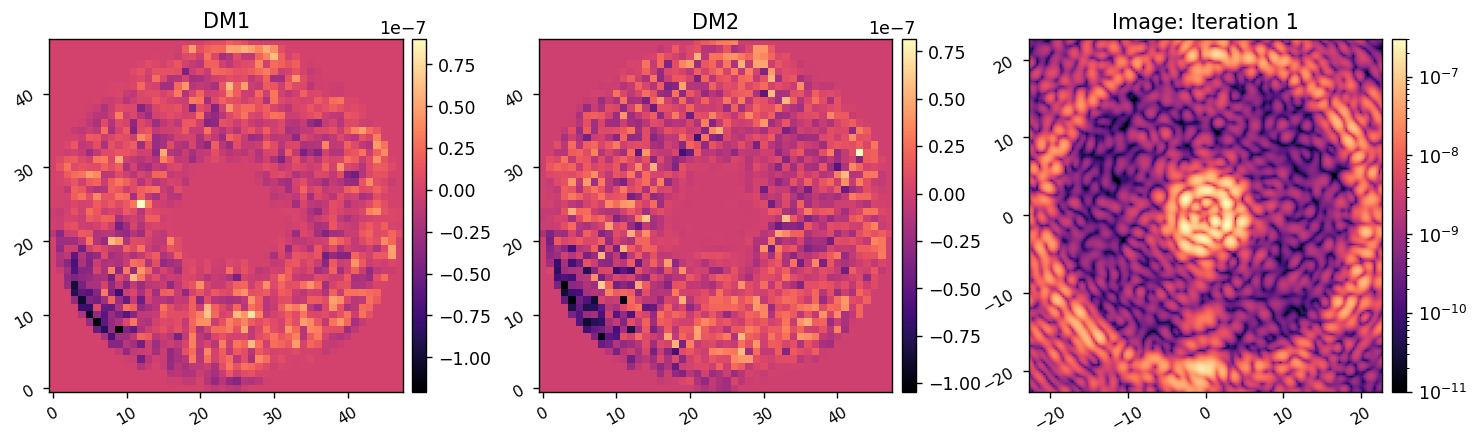

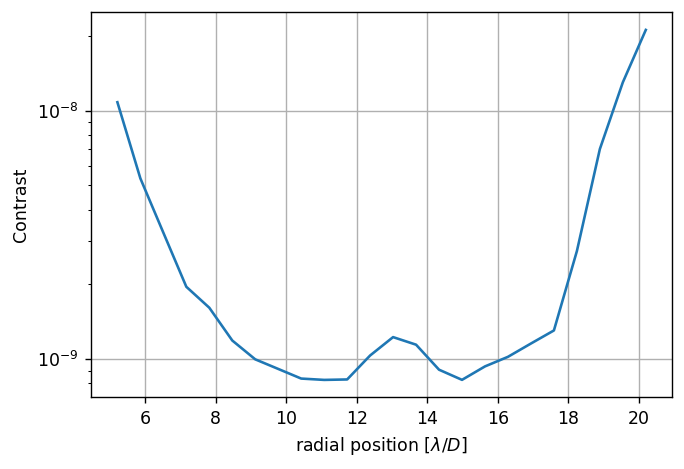

	Closed-loop iteration 2 / 5


(3560,)

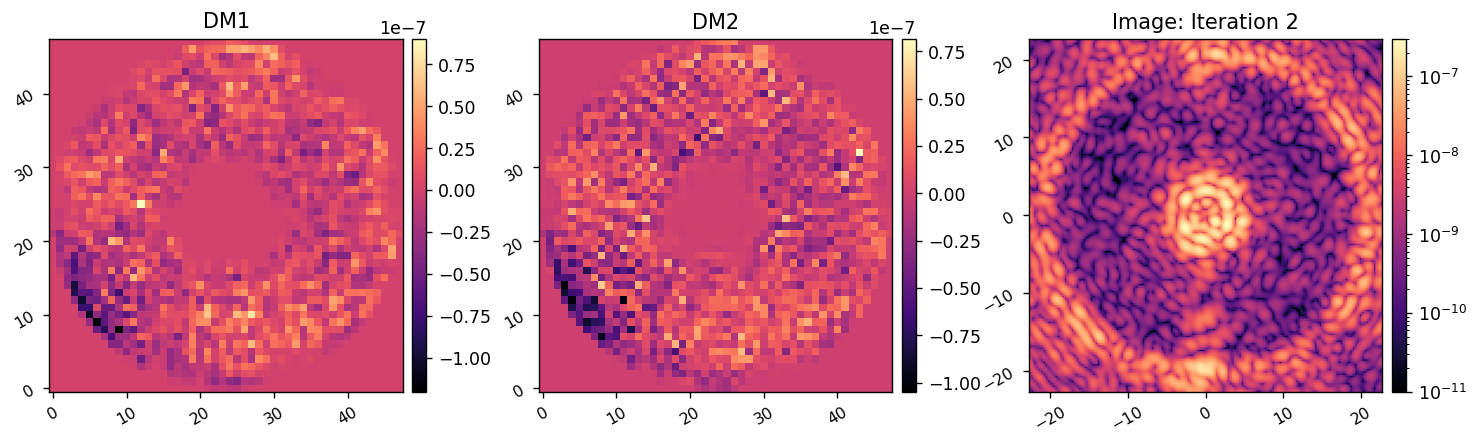

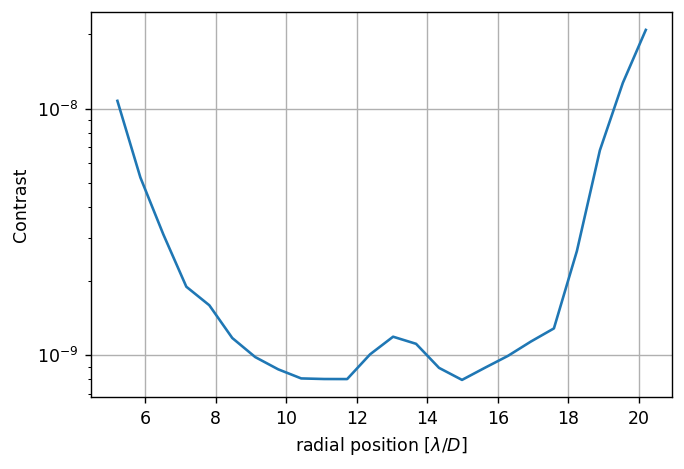

	Closed-loop iteration 3 / 5


(3560,)

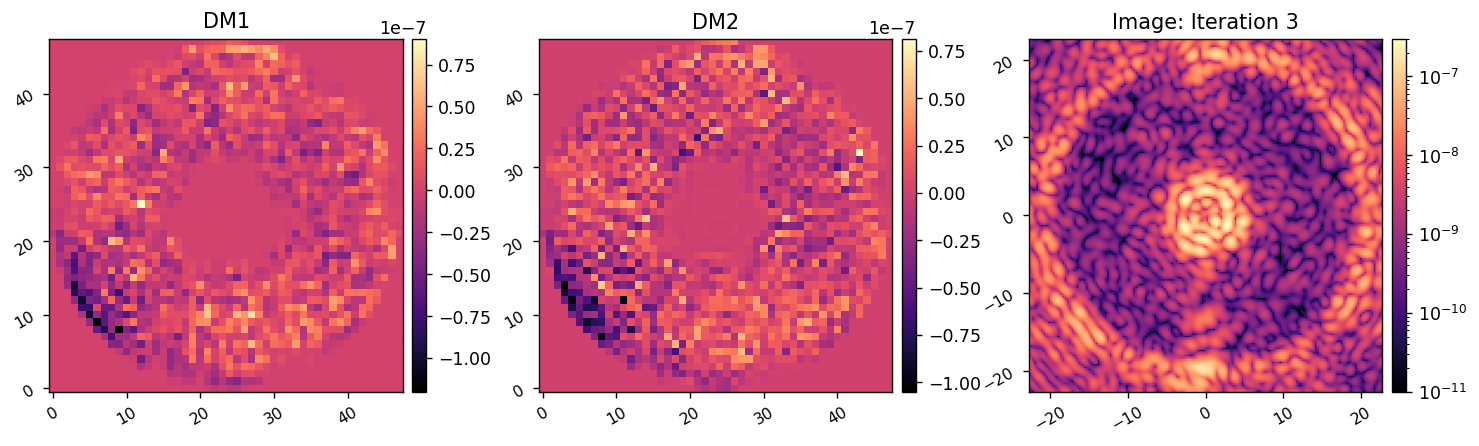

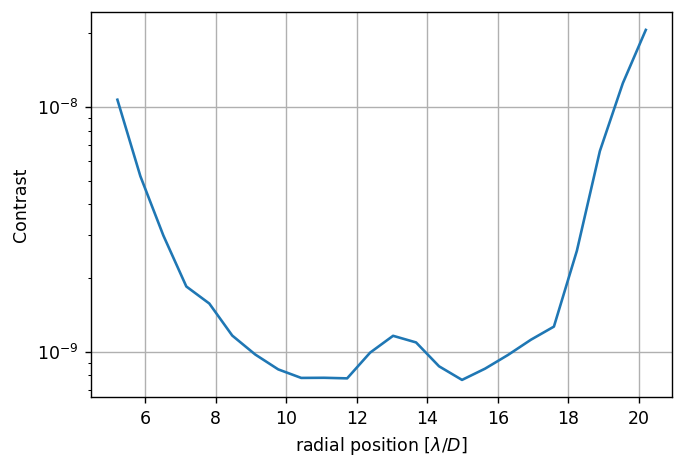

	Closed-loop iteration 4 / 5


(3560,)

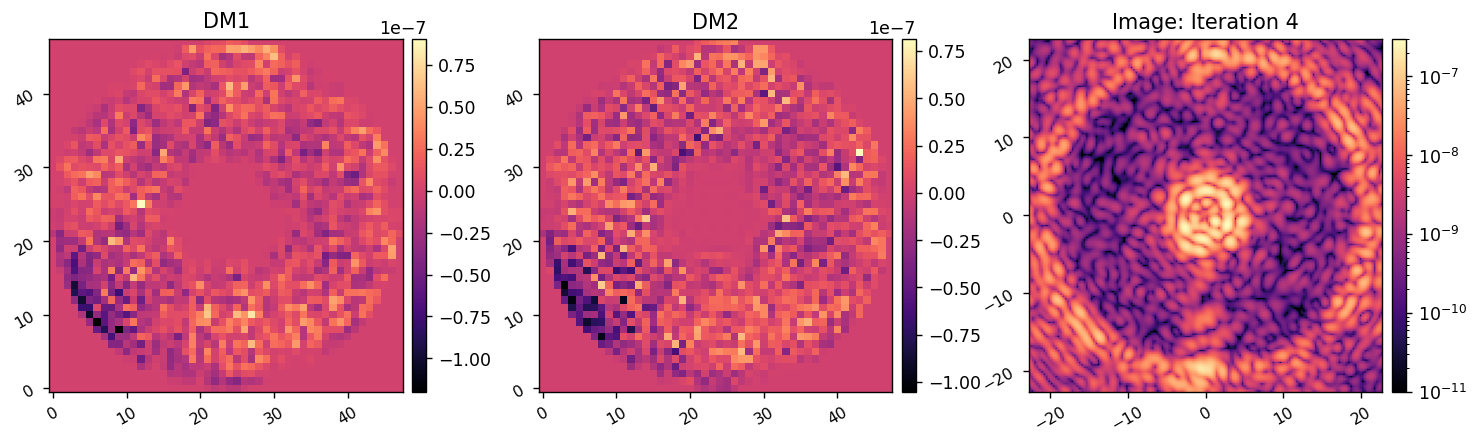

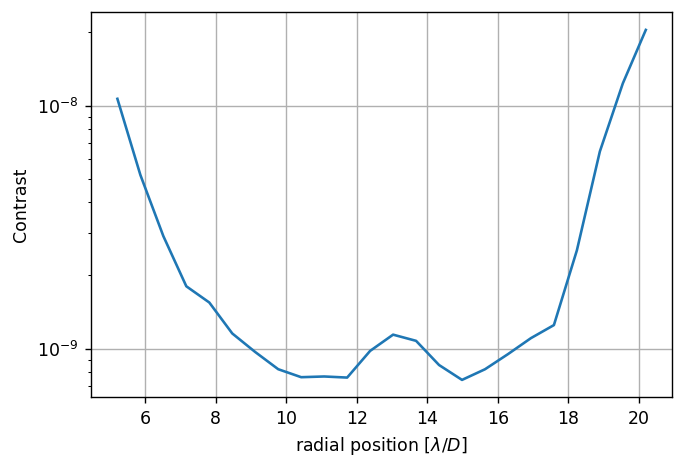

	Closed-loop iteration 5 / 5


(3560,)

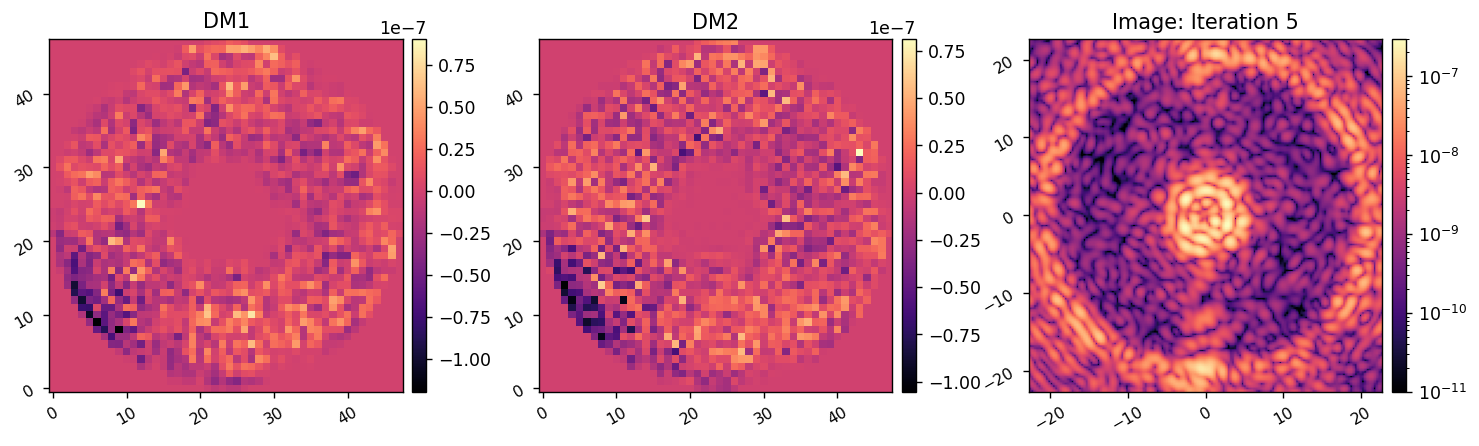

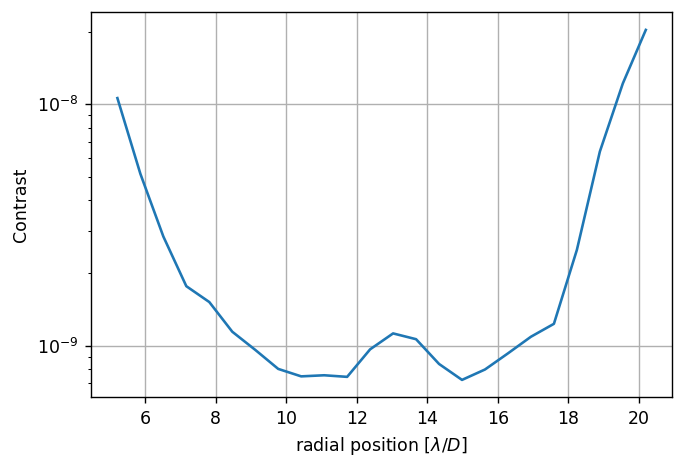

I-EFC loop completed in 11.460s.


In [28]:
reg_cond = 1e-4
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

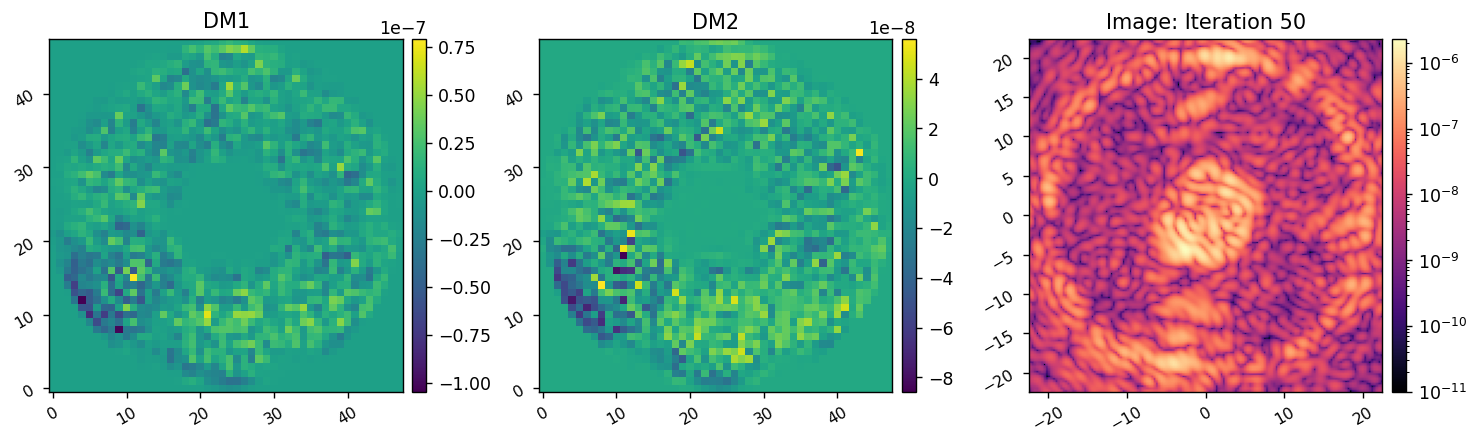

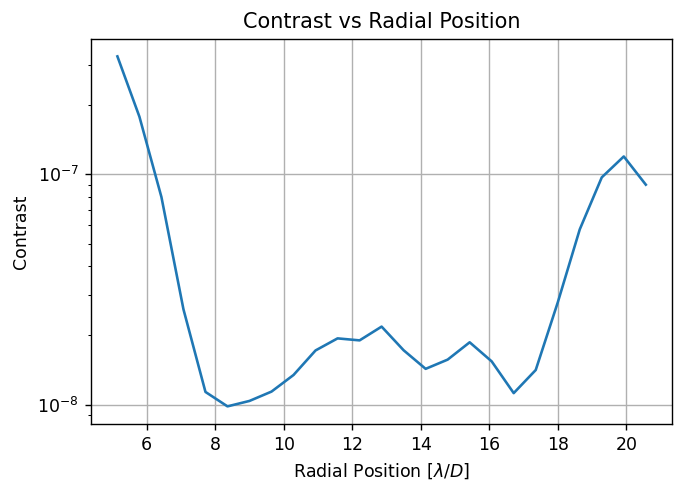

Closed loop for given control matrix completed in 116.948s.


In [89]:
reload(iefc_2dm)
reload(utils)

mode.reset_dms()

reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])

images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                          control_matrix,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=50, 
                                          loop_gain=0.5, 
                                          leakage=0,
#                                           plot_all=True,
                                         plot_radial_contrast=True
                                         )


Running iEFC...
	Closed-loop iteration 136 / 140
	Mean NI of this iteration: 4.246e-09


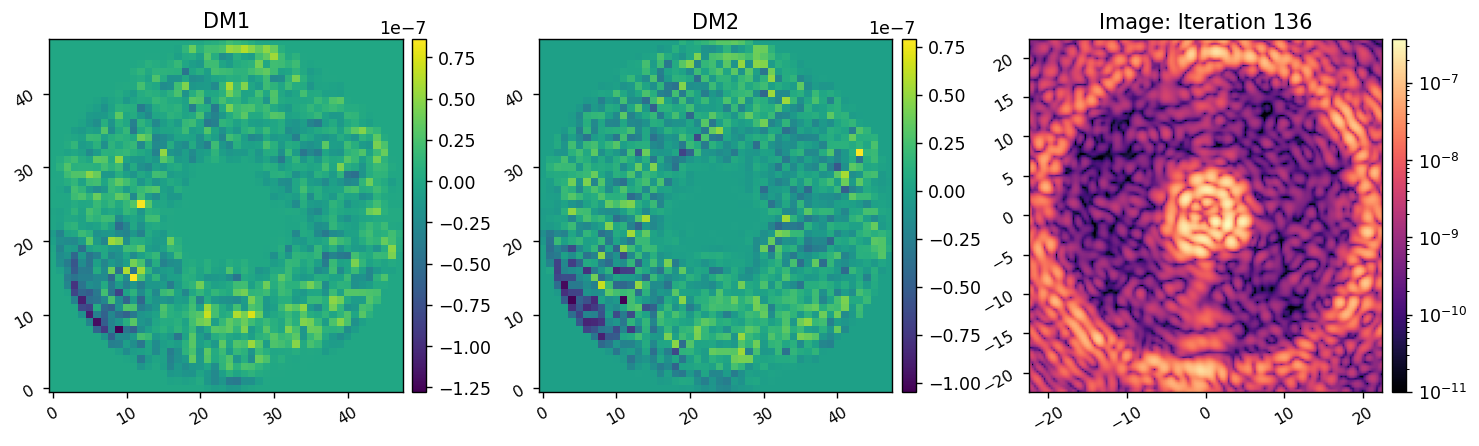

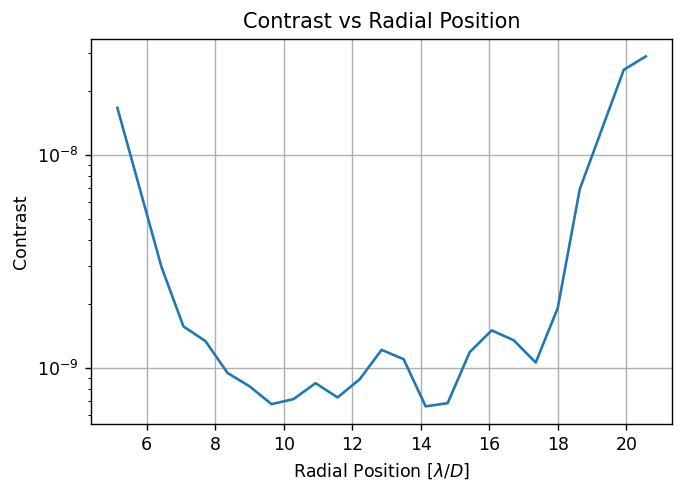

	Closed-loop iteration 137 / 140
	Mean NI of this iteration: 4.230e-09


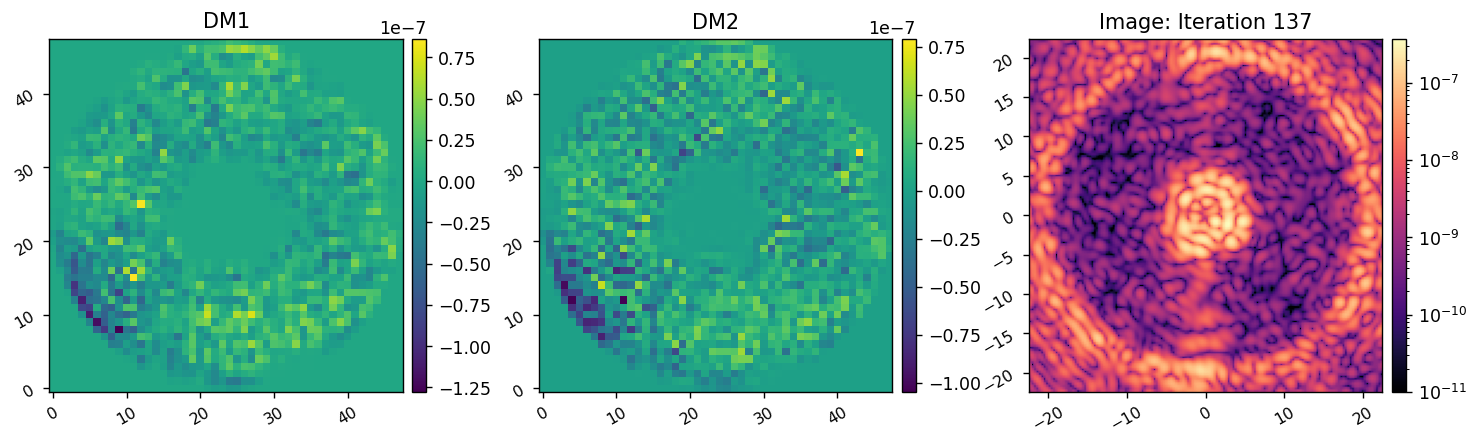

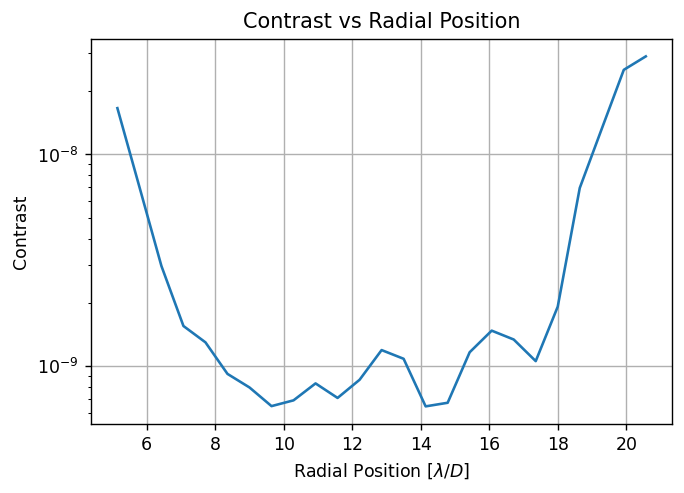

	Closed-loop iteration 138 / 140
	Mean NI of this iteration: 4.215e-09


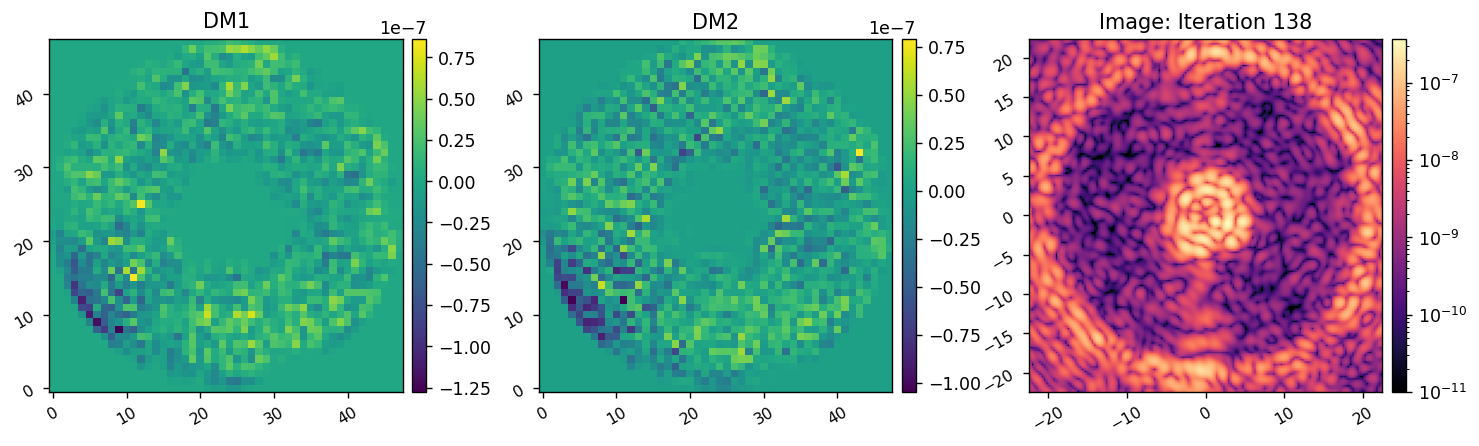

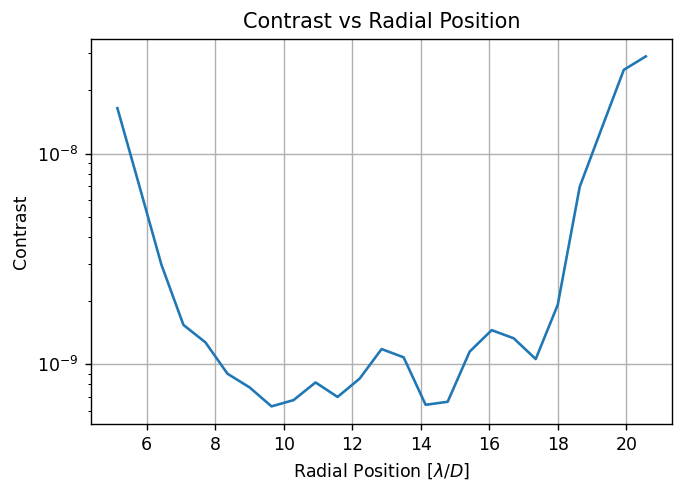

	Closed-loop iteration 139 / 140
	Mean NI of this iteration: 4.200e-09


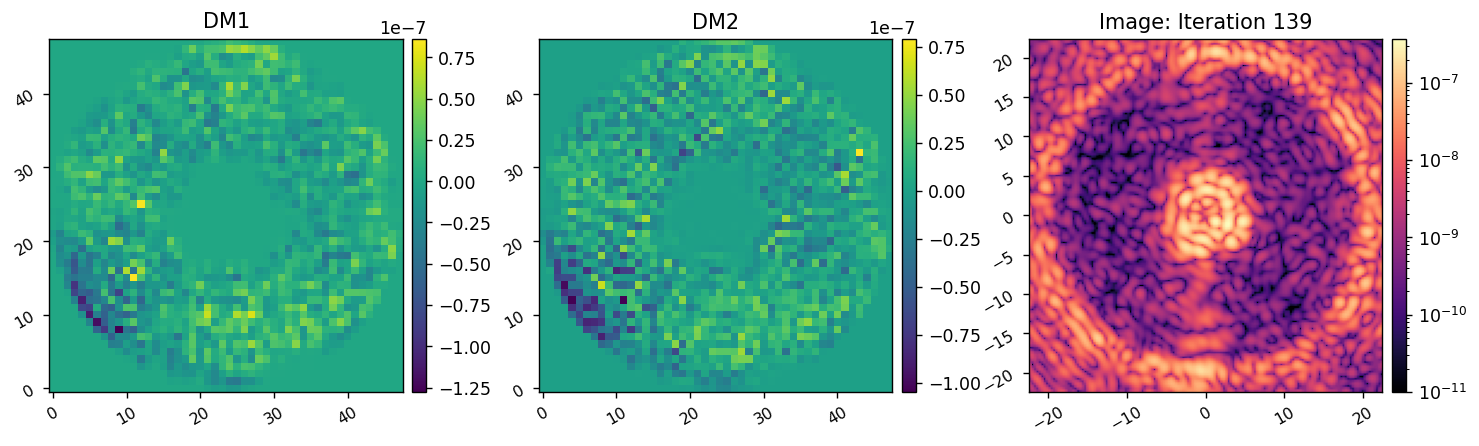

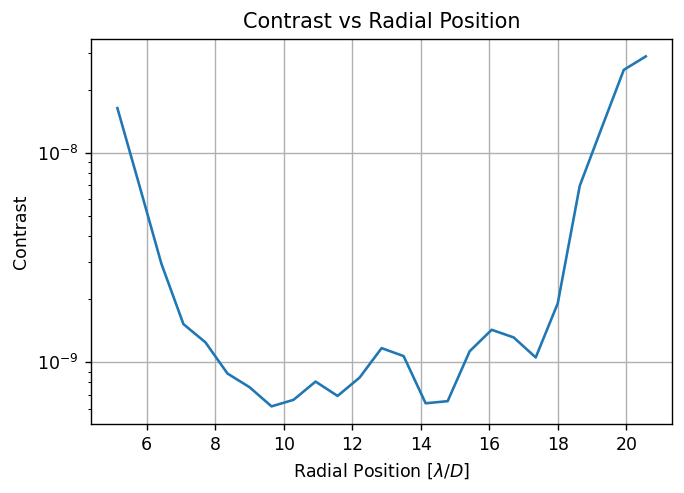

	Closed-loop iteration 140 / 140
	Mean NI of this iteration: 4.186e-09


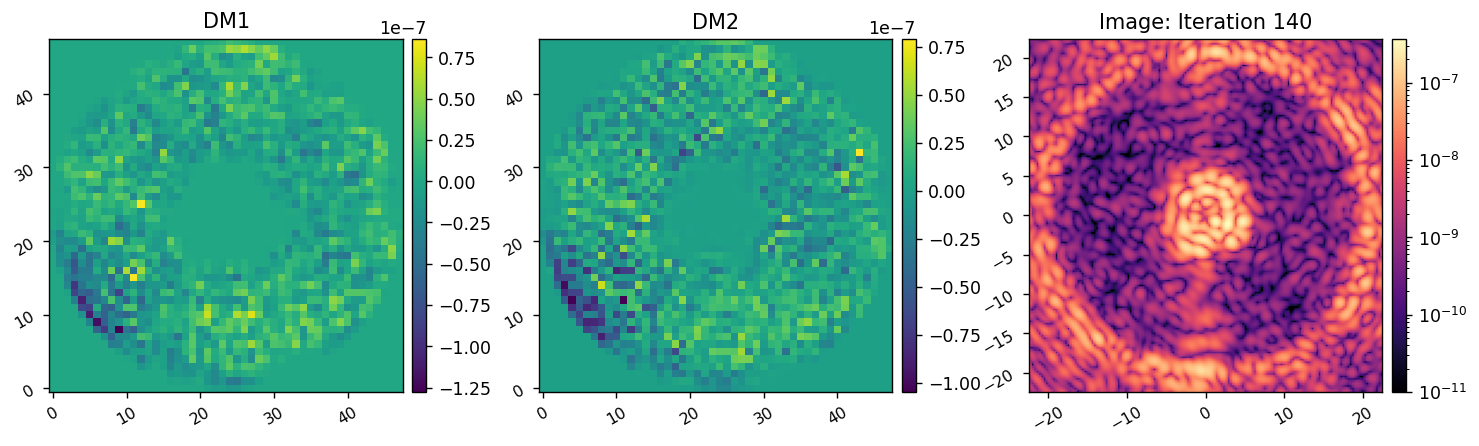

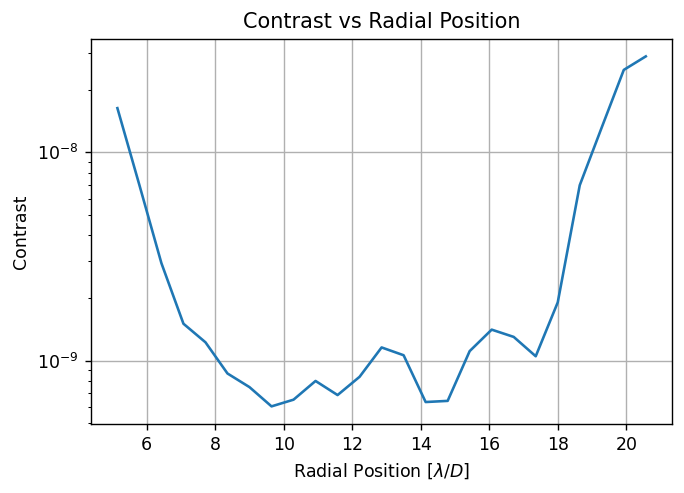

Closed loop for given control matrix completed in 12.659s.


In [107]:
reload(iefc_2dm)

Nitr = 5
reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                                  control_matrix,
                                                  probe_modes, 
                                                  probe_amp, 
                                                  ensure_np_array(calib_modes),
                                                  control_mask, 
                                                  num_iterations=Nitr, 
#                                                   starting_iteration=0,
                                                  loop_gain=0.5, 
                                                  leakage=0,
                                                  plot_all=True,
                                                  plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                                 )

Running iEFC...
	Closed-loop iteration 96 / 100
	Mean NI of this iteration: 3.594e-09


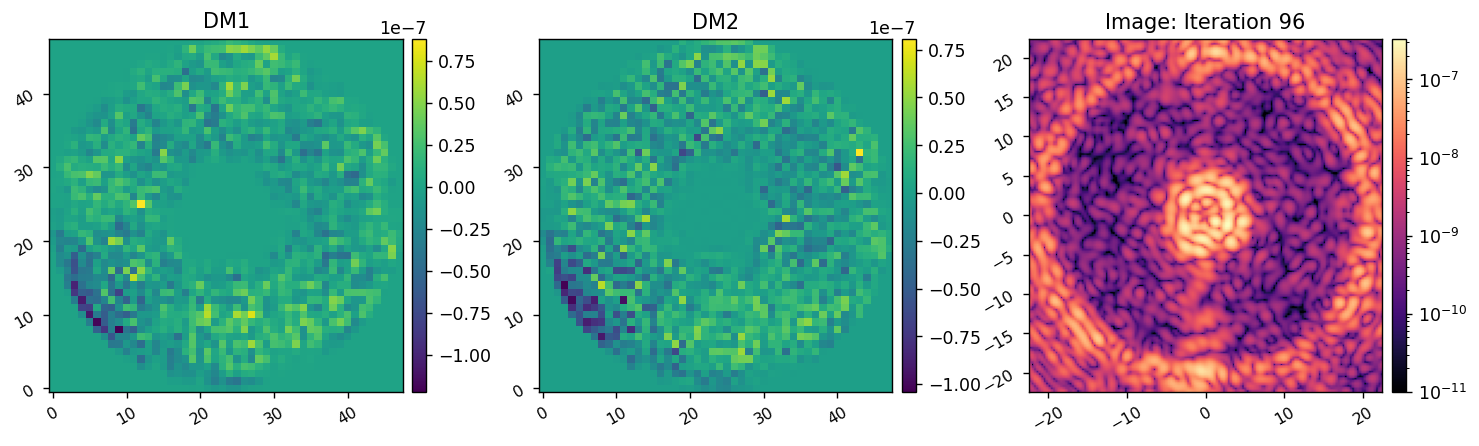

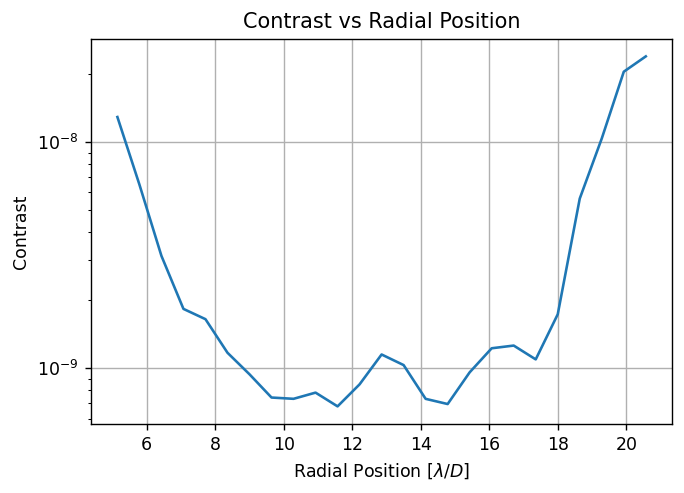

	Closed-loop iteration 97 / 100
	Mean NI of this iteration: 3.566e-09


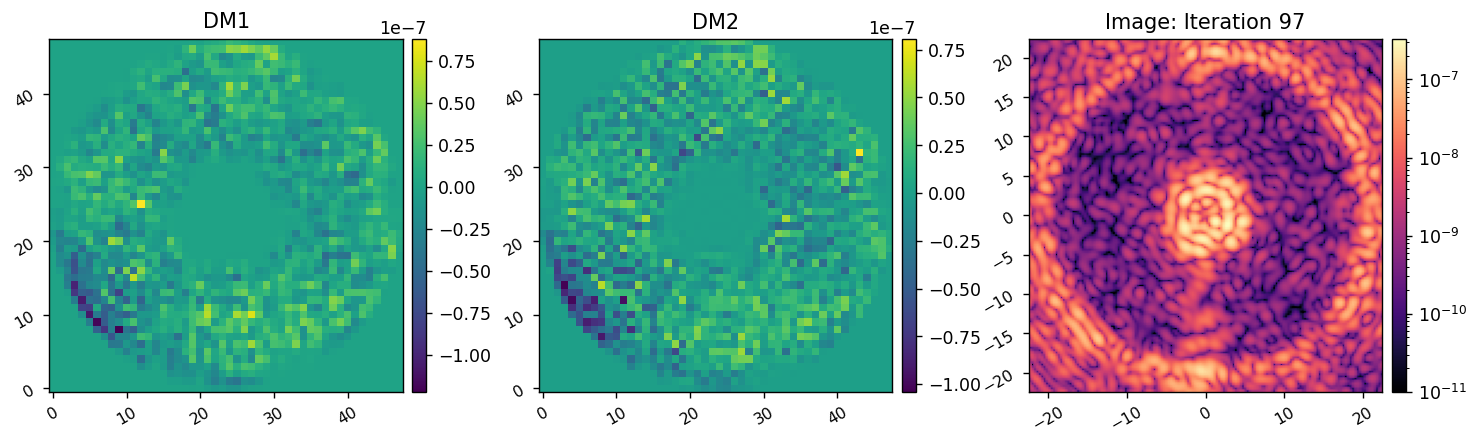

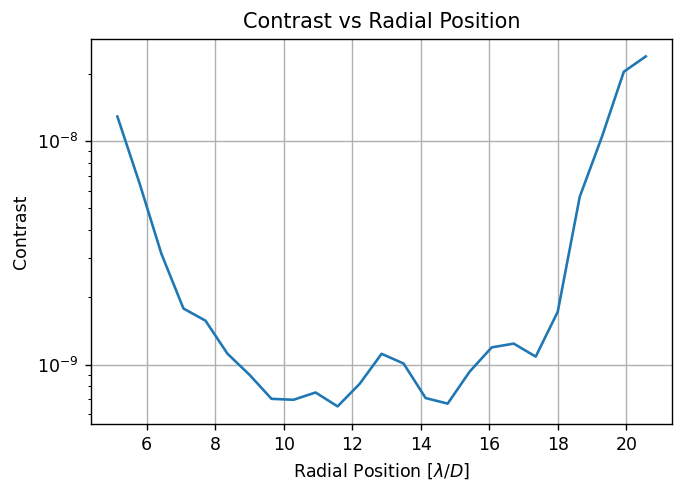

	Closed-loop iteration 98 / 100
	Mean NI of this iteration: 3.543e-09


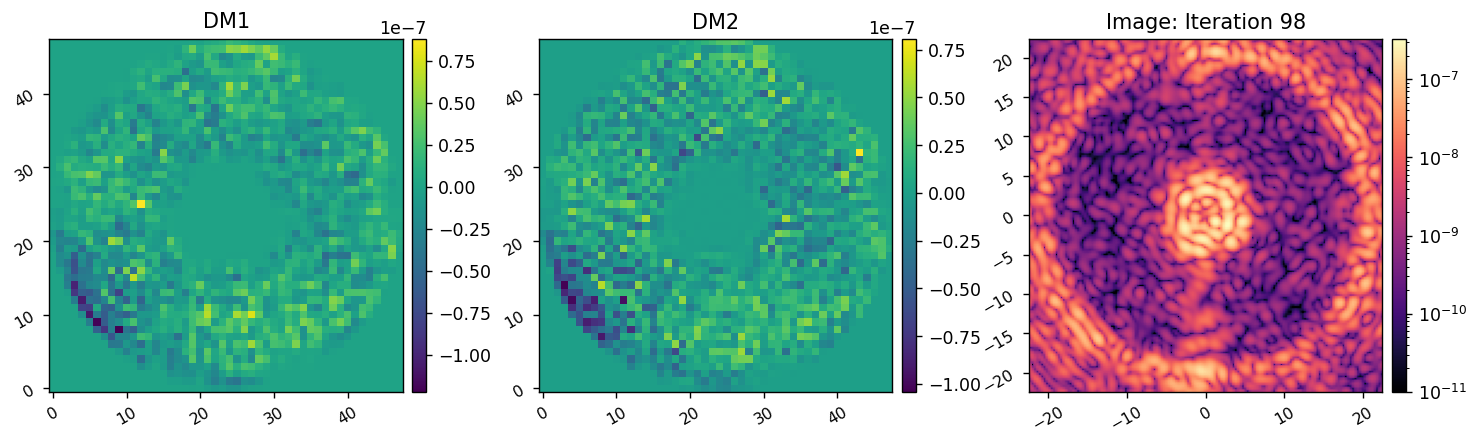

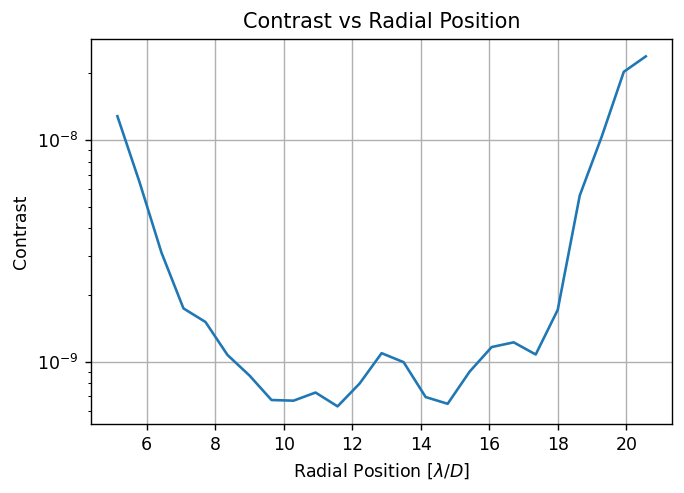

	Closed-loop iteration 99 / 100
	Mean NI of this iteration: 3.522e-09


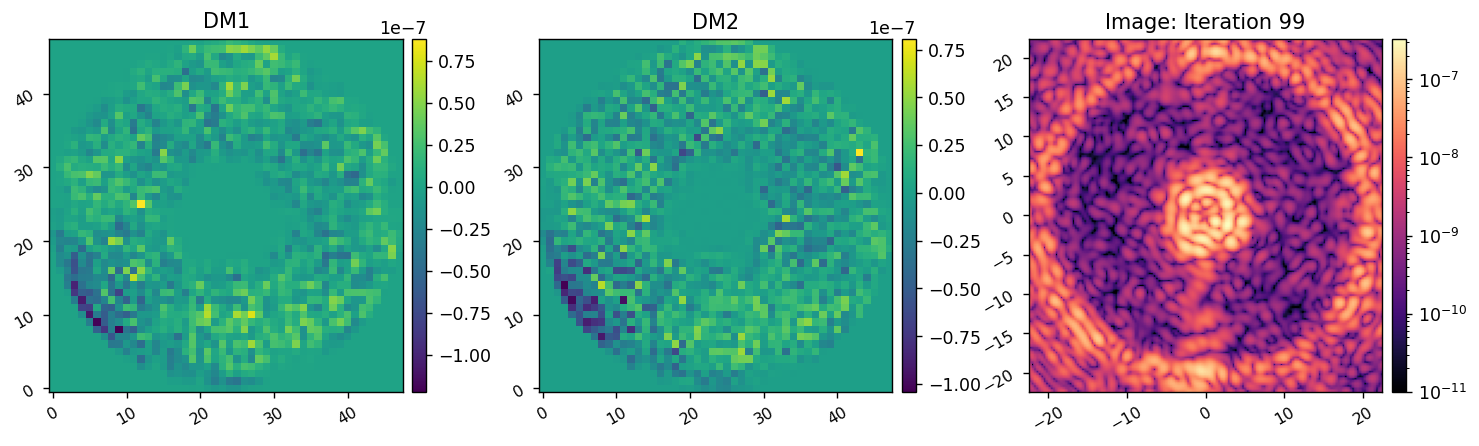

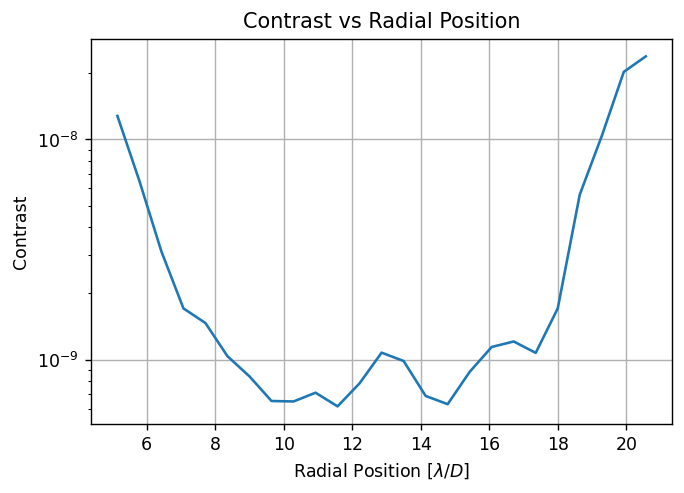

	Closed-loop iteration 100 / 100
	Mean NI of this iteration: 3.503e-09


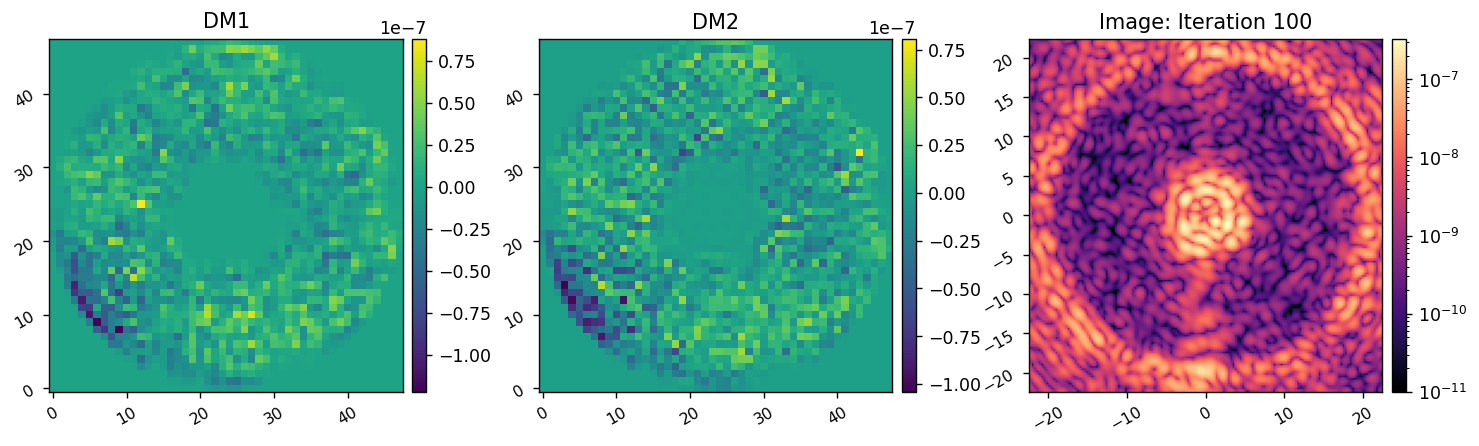

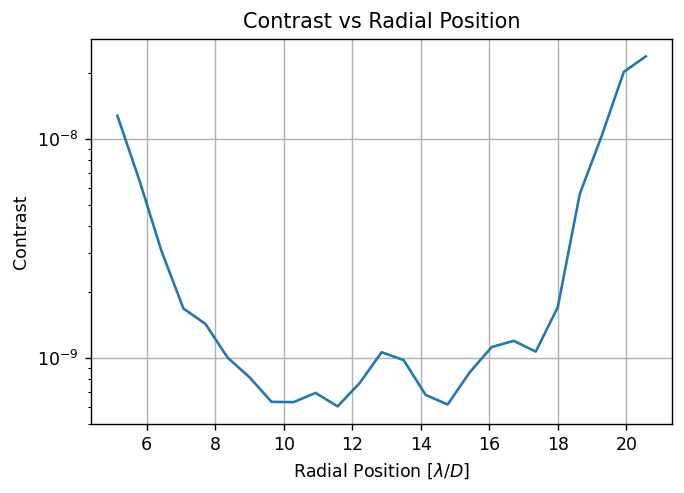

Closed loop for given control matrix completed in 12.422s.


In [64]:
reload(iefc_2dm)

Nitr = 5
reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, nprobes=probe_modes.shape[0])
        
images, dm1_commands, dm2_commands = iefc_2dm.run(mode, 
                                                  control_matrix,
                                                  probe_modes, 
                                                  probe_amp, 
                                                  ensure_np_array(calib_modes),
                                                  control_mask, 
                                                  num_iterations=Nitr, 
#                                                   starting_iteration=0,
                                                  loop_gain=0.5, 
                                                  leakage=0,
                                                  plot_all=True,
                                                  plot_radial_contrast=True,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                                 )